In [1]:
# You may need to run this first- uncomment if so
#!pip install python-crfsuite

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [4]:
#Below are the dataset as given with the assignment
given_raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 
given_training_data = [preProcess(example) for example in given_raw_training_data]

given_raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
given_test_data = [preProcess(example) for example in given_raw_test_data]


In [5]:
print("Training set as given:")
print(len(given_training_data), "instances")
print(sum([len(sent) for sent in given_training_data]), "words\n")
print("Test set as given:")
print(len(given_test_data), "instances")
print(sum([len(sent) for sent in given_test_data]), "words")

Training set as given:
7816 instances
158823 words

Test set as given:
1953 instances
39035 words


In [6]:
#Answer to Q1: Spliting the data in trivia10k13train.bio.txt to 80% train and 20% test without preprocessing
raw_train_data, raw_test_data = train_test_split(given_raw_training_data, test_size=0.2, random_state=42)

q1_training_data = [preProcess(example) for example in raw_train_data]
q1_test_data = [preProcess(example) for example in raw_test_data]


In [7]:
print("Training set after splitting:")
print(len(raw_train_data), "instances")
print(sum([len(sent) for sent in raw_train_data]), "words\n")
print("Test set after splitting:")
print(len(raw_test_data), "instances")
print(sum([len(sent) for sent in raw_test_data]), "words")

Training set after splitting:
6252 instances
126934 words

Test set after splitting:
1564 instances
31889 words


In [8]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def given_get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [9]:
# Train the CRF BIO-tag tagger on the given data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here

In [10]:

given_ct = CRFTagger(feature_func=given_get_features)  # initialize tagger with get_features function

print("training tagger on the given data...")
given_ct.train(given_training_data, TAGGER_PATH)
print("done")

given_ct.set_model_file(TAGGER_PATH) 


training tagger on the given data...
done


In [11]:
print("testing tagger on given data...")
given_preds = []
given_y_test = []
for sent in given_test_data:
    sent_preds = [x[1] for x in given_ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    given_preds.extend(sent_preds)
    given_y_test.extend(sent_true)
print("done")

testing tagger on given data...
done


In [12]:
#Classification report for given train and test data
given_clReport = classification_report(given_y_test, given_preds)
given_prfsReport = precision_recall_fscore_support(given_y_test, given_preds, average='macro') 

print(given_clReport)
print(given_prfsReport)


/Users/nish/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.85      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.80       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.82      0.30      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

In [13]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

/Users/nish/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Award', 'I-Award', 'I-Relationship', 'B-Character_Name', 'I-Quote', 'I-Origin', 'B-Origin', 'B-Actor', 'B-Quote', 'I-Character_Name', 'B-Plot', 'I-Year', 'B-Genre', 'I-Actor', 'B-Opinion', 'I-Plot', 'O', 'I-Genre', 'B-Year', 'B-Director', 'I-Director', 'B-Relationship'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


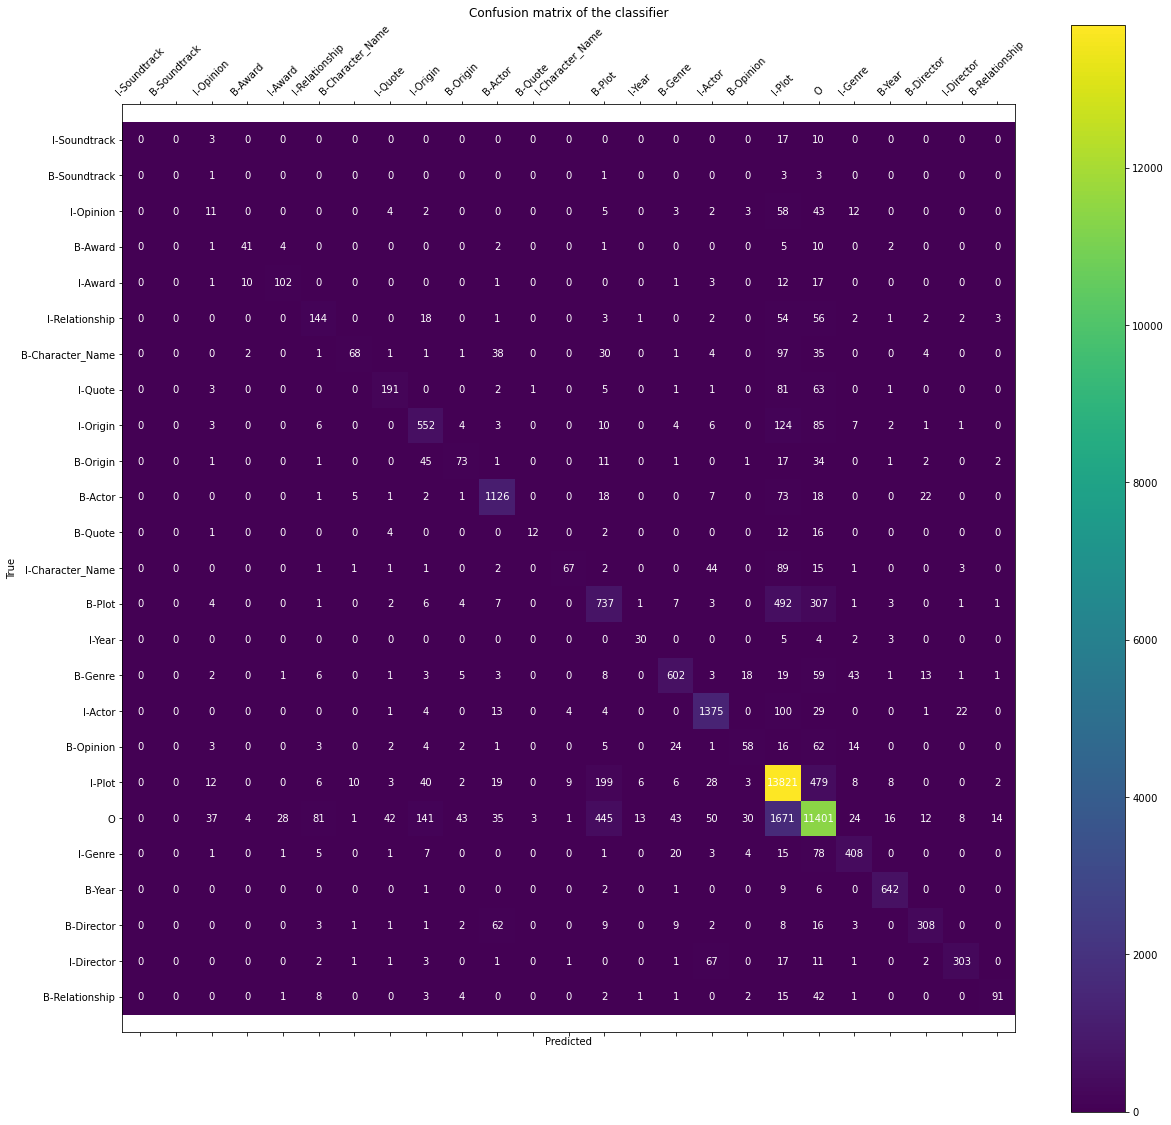

In [14]:
#Confusion matrix for given train and test data
confusion_matrix_heatmap(given_y_test, given_preds)

In [15]:
#Training tagger on the train data from the 80/20 split (Q1)
q1_ct = CRFTagger(feature_func=given_get_features)
print("training tagger on the split data...")
q1_ct.train(q1_training_data, TAGGER_PATH)
print("done")

q1_ct.set_model_file(TAGGER_PATH) 

training tagger on the split data...
done


In [16]:
#Testing tagger on the test data from the 80/20 split (Q1)
print("testing tagger on split data...")
q1_preds = []
q1_y_test = []
for sent in q1_test_data:
    sent_preds = [x[1] for x in q1_ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    q1_preds.extend(sent_preds)
    q1_y_test.extend(sent_true)
print("done")

testing tagger on split data...
done


In [17]:
#Classification report for 80/20 split data (Q1)
q1_clReport = classification_report(q1_y_test, q1_preds)
q1_prfsReport = precision_recall_fscore_support(q1_y_test, q1_preds, average='macro')

print(q1_clReport)
print(q1_prfsReport)


                  precision    recall  f1-score   support

         B-Actor       0.87      0.88      0.87       967
         B-Award       0.79      0.60      0.68        62
B-Character_Name       0.76      0.24      0.36       217
      B-Director       0.79      0.68      0.73       357
         B-Genre       0.81      0.72      0.76       684
       B-Opinion       0.39      0.27      0.32       165
        B-Origin       0.52      0.32      0.40       157
          B-Plot       0.48      0.44      0.46      1321
         B-Quote       0.22      0.11      0.14        19
  B-Relationship       0.76      0.45      0.56       134
    B-Soundtrack       0.00      0.00      0.00        11
          B-Year       0.96      0.96      0.96       500
         I-Actor       0.87      0.87      0.87      1179
         I-Award       0.72      0.78      0.75       124
I-Character_Name       0.68      0.27      0.39       141
      I-Director       0.84      0.70      0.76       316
         I-Ge

In [18]:
#Comparing the precision, recall, f1-score, and support for before and after splitting
print("Before splitting: ", given_prfsReport)
print("After splitting : ", q1_prfsReport)

Before splitting:  (0.6581485250363811, 0.5495470870201031, 0.5838971371849242, None)
After splitting :  (0.6064850392545966, 0.513915038409207, 0.5454202155753599, None)


/Users/nish/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Award', 'I-Award', 'B-Character_Name', 'I-Quote', 'I-Origin', 'B-Origin', 'B-Actor', 'B-Quote', 'I-Character_Name', 'B-Year', 'B-Plot', 'I-Year', 'B-Genre', 'I-Actor', 'B-Opinion', 'I-Plot', 'O', 'I-Genre', 'I-Relationship', 'B-Director', 'I-Director', 'B-Relationship'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


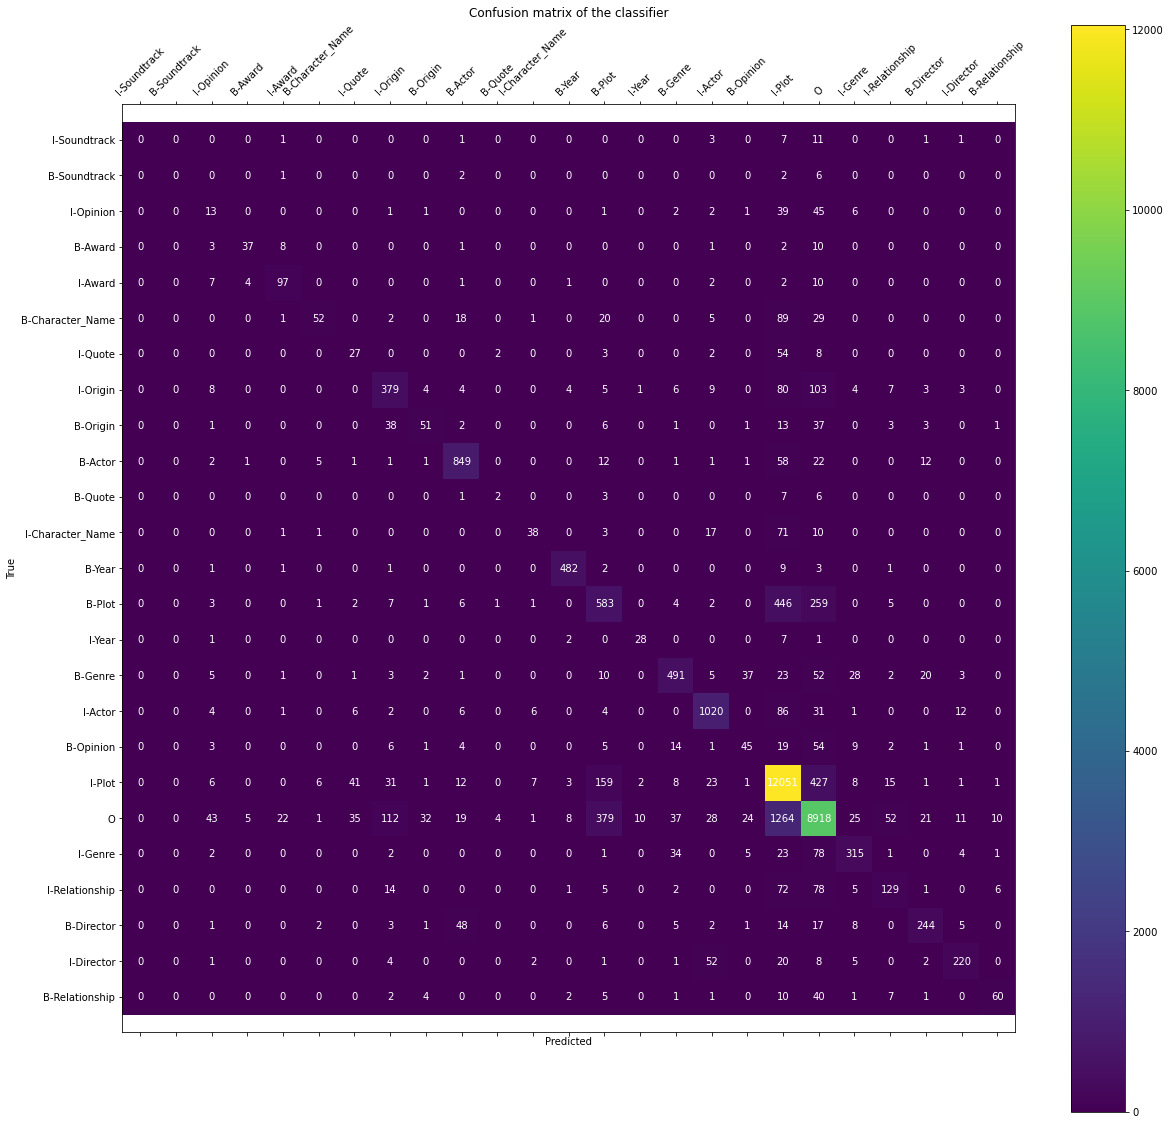

In [19]:
#Confusion matrix for 80/20 split data (Q1)
confusion_matrix_heatmap(q1_y_test, q1_preds)

In [20]:
result = pd.DataFrame(classification_report(q1_y_test, q1_preds, output_dict=True)).transpose()

In [21]:
#Ansewer to question 2: False Positives

least_precision = result.sort_values(by=['precision'])[:5].index.values.tolist()
#least_precision = ['I-Opinion']
print("Five classes with least precision are ", least_precision, "\n")
falsePositives = 0 
#Using test set created for question 1
for sent in q1_test_data:
    value_preds = [x[0] for x in q1_ct.tag([s[0] for s in sent])]
    sent_preds = [x[1] for x in q1_ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    
    for pred, true, value in zip(sent_preds, sent_true, value_preds):
        if (pred not in least_precision):
            continue
        if(pred == true):
            continue
        falsePositives += 1
        print('FALSE POSITIVE', falsePositives, ':\n')
        print("For {0} (ground truth = {1}) on the word '{2}' in the sentence: \n".format(pred, true, value))
        print(' '.join(value_preds),"\n")
        print('*'*100, '\n')
print("Total number of False Positives for 5 classes with least precision =", falsePositives)


Five classes with least precision are  ['B-Soundtrack', 'I-Soundtrack', 'I-Opinion', 'B-Quote', 'I-Quote'] 

FALSE POSITIVE 1 :

For B-Quote (ground truth = B-Plot) on the word 'how' in the sentence: 

what is the name of the fifth movie in the series about how you ca n t cheat death or fate 

**************************************************************************************************** 

FALSE POSITIVE 2 :

For I-Quote (ground truth = I-Plot) on the word 'you' in the sentence: 

what is the name of the fifth movie in the series about how you ca n t cheat death or fate 

**************************************************************************************************** 

FALSE POSITIVE 3 :

For I-Quote (ground truth = I-Plot) on the word 'ca' in the sentence: 

what is the name of the fifth movie in the series about how you ca n t cheat death or fate 

**************************************************************************************************** 

FALSE POSITIVE 4 :

For I

In [22]:
#Ansewer to question 3: False Negatives

least_recall = result.sort_values(by=['recall'])[:5].index.values.tolist()
#least_recall = ['B-Character_Name']
print("Five classes with least recall are ", least_recall, "\n")
falseNegatives = 0 
#Using test set created for question 1
for sent in q1_test_data:
    value_preds = [x[0] for x in q1_ct.tag([s[0] for s in sent])]
    sent_preds = [x[1] for x in q1_ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    
    for pred, true, value in zip(sent_preds, sent_true, value_preds):
        if (true not in least_recall):
            continue
        if(true == pred):
            continue
        falseNegatives += 1
        print('FALSE NEGATIVE', falseNegatives, ':\n')
        print("For {0} (prediction = {1}) on the word '{2}' in the sentence: \n".format(true, pred, value))
        print(' '.join(value_preds),"\n")
        print('*'*100, '\n')
print("Total number of False Negatives for 5 classes with least recall =", falseNegatives)

Five classes with least recall are  ['I-Soundtrack', 'B-Soundtrack', 'B-Quote', 'I-Opinion', 'B-Character_Name'] 

FALSE NEGATIVE 1 :

For B-Character_Name (prediction = I-Plot) on the word 'thumper' in the sentence: 

what is the name of the disney classic featuring woodland animals and a bunny named thumper 

**************************************************************************************************** 

FALSE NEGATIVE 2 :

For B-Character_Name (prediction = I-Plot) on the word 'loki' in the sentence: 

what is the marvel comic movie about the god of thunder who comes to earth and fights his brother loki 

**************************************************************************************************** 

FALSE NEGATIVE 3 :

For B-Character_Name (prediction = I-Plot) on the word 'alex' in the sentence: 

what s the kubrick film set in the future and involves alex and his band of thugs 

******************************************************************************************

In [23]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [24]:
#Answer to Q4: add tags using the given 'posttagger'. Concatenate the word and tag with '@' in between for easy splitting
def preProcess_addTags(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

   # preprocessed_example = example  # trivial- no preprocessing
    #return preprocessed_example
    addTags = posttagger.tag([x[0] for x in example]) #adding tags
    concat = ['@'.join(x) for x in addTags] #concatenating the word and POS tag with symbol @ in between for easy splitting
    return list(zip(concat, [x[1] for x in example])) #returns concatenated string and the BIO tag
    

In [25]:
q4_training_data = [preProcess_addTags(example) for example in raw_train_data]
q4_test_data = [preProcess_addTags(example) for example in raw_test_data]

In [26]:

# Splitting the concatenated data
def get_features_withTags(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    tag = token.split("@")[1]
    token = token.split("@")[0]
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    feature_list.append("WTAG_" + tag) #Adding POS tag as feature
    
    return feature_list

In [27]:
q4_ct = CRFTagger(feature_func=get_features_withTags)  # initialize tagger with get_features function

print("training tagger...")
q4_ct.train(q4_training_data, TAGGER_PATH)
print("done")

q4_ct.set_model_file(TAGGER_PATH) 


training tagger...
done


In [28]:
print("testing tagger...")
q4_preds = []
q4_y_test = []
for sent in q4_test_data:
    sent_preds = [x[1] for x in q4_ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    q4_preds.extend(sent_preds)
    q4_y_test.extend(sent_true)
print("done")

testing tagger...
done


In [29]:
q4_clReport = classification_report(q4_y_test, q4_preds)
q4_prfsReport = precision_recall_fscore_support(q4_y_test, q4_preds, average='macro')

print(q4_clReport)
print(q4_prfsReport)

                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.88       967
         B-Award       0.81      0.61      0.70        62
B-Character_Name       0.68      0.24      0.35       217
      B-Director       0.78      0.70      0.74       357
         B-Genre       0.82      0.72      0.77       684
       B-Opinion       0.43      0.31      0.36       165
        B-Origin       0.51      0.34      0.41       157
          B-Plot       0.49      0.45      0.47      1321
         B-Quote       0.40      0.21      0.28        19
  B-Relationship       0.75      0.46      0.57       134
    B-Soundtrack       0.00      0.00      0.00        11
          B-Year       0.96      0.97      0.96       500
         I-Actor       0.86      0.90      0.88      1179
         I-Award       0.75      0.79      0.77       124
I-Character_Name       0.61      0.31      0.41       141
      I-Director       0.83      0.72      0.77       316
         I-Ge

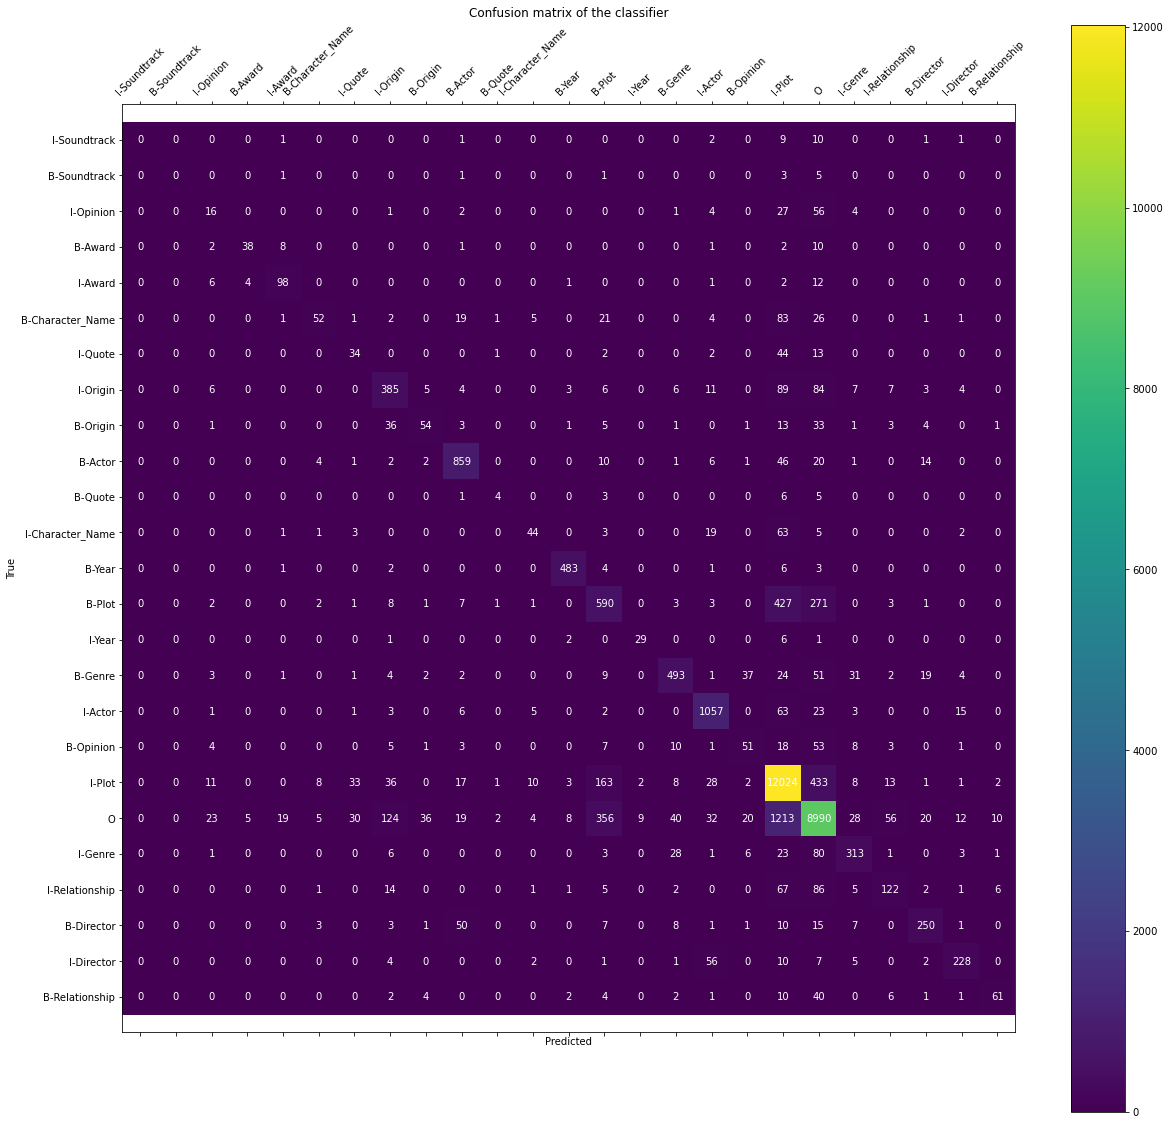

In [30]:
confusion_matrix_heatmap(q4_y_test, q4_preds)

In [31]:
#comparing
print("Before splitting:", given_prfsReport)
print("After splitting :", q1_prfsReport)
print("Afer tagging    :", q4_prfsReport)

Before splitting: (0.6581485250363811, 0.5495470870201031, 0.5838971371849242, None)
After splitting : (0.6064850392545966, 0.513915038409207, 0.5454202155753599, None)
Afer tagging    : (0.6170083344014887, 0.5315958855358179, 0.5622765677918949, None)


In [32]:
'''Feature set 1: Removed capitalization, punctuation, number, word and it's POS tag. 
Added next and previous word
Added c1 and c2 regularization parameters'''

def get_features_set1(tokens, idx):

    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    tag = token.split("@")[1]
    token = token.split("@")[0]

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    # Next word
    if idx < len(tokens) - 1:
        feature_list.append("NEXT_" + tokens[idx + 1].split("@")[0])
        
   # Previous word
    if idx > 0:
        feature_list.append("PREV_" + tokens[idx - 1].split("@")[0])

    #print(feature_list)
    return feature_list


In [33]:
q5_ct = CRFTagger(feature_func=get_features_set1, training_opt={"c1": 0.2, "c2": 0.3})  

print("training tagger...")
q5_ct.train(q4_training_data, TAGGER_PATH)
print("done")

q5_ct.set_model_file(TAGGER_PATH) 

training tagger...
done


In [52]:
print("testing tagger...")
q5_preds = []
q5_y_test = []
for sent in q4_test_data:
    sent_preds = [x[1] for x in q5_ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    q5_preds.extend(sent_preds)
    q5_y_test.extend(sent_true)
print("done")

testing tagger...
done


In [53]:
# q5I1 = Question 5 Iteration 1
q5I1_clReport = classification_report(q5_y_test, q5_preds)
q5I1_prfsReport = precision_recall_fscore_support(q5_y_test, q5_preds, average='macro')

print(q5I1_clReport)
print(q5I1_prfsReport)

                  precision    recall  f1-score   support

         B-Actor       0.92      0.90      0.91       967
         B-Award       0.75      0.65      0.70        62
B-Character_Name       0.84      0.36      0.50       217
      B-Director       0.77      0.77      0.77       357
         B-Genre       0.79      0.73      0.75       684
       B-Opinion       0.46      0.36      0.40       165
        B-Origin       0.50      0.36      0.42       157
          B-Plot       0.50      0.46      0.48      1321
         B-Quote       0.69      0.47      0.56        19
  B-Relationship       0.69      0.47      0.56       134
    B-Soundtrack       0.67      0.18      0.29        11
          B-Year       0.97      0.97      0.97       500
         I-Actor       0.92      0.89      0.90      1179
         I-Award       0.76      0.85      0.80       124
I-Character_Name       0.82      0.42      0.55       141
      I-Director       0.80      0.78      0.79       316
         I-Ge

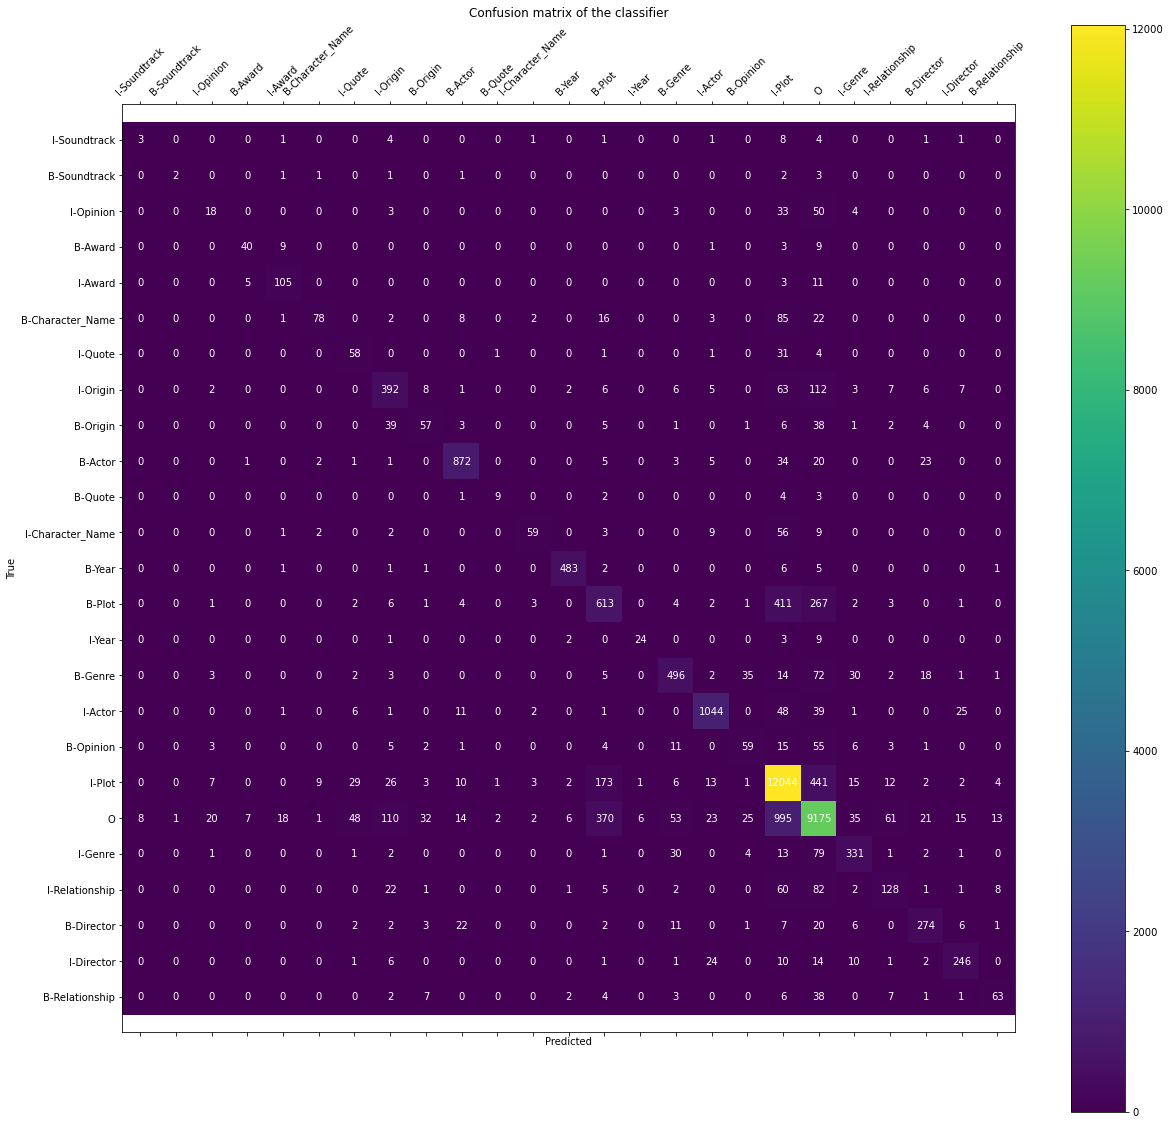

In [54]:
confusion_matrix_heatmap(q5_y_test, q5_preds)

In [55]:
'''Feature set 2: contains capitalization, punctuation, number, word and it's POS tag, 
    next word and it's POS tag, previous word and it's POS tag,
    suffix upto length 4, prefix upto length 4 '''

def get_features_set2(tokens, idx):

    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    tag = token.split("@")[1]
    token = token.split("@")[0]

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    #punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    #if all(unicodedata.category(x) in punc_cat for x in token):
        #feature_list.append("PUNCTUATION")
    
    # Word
    feature_list.append("WORD_" + token)
    
    # Word POS tag
    feature_list.append("WTAG_" + tag) 
        
    # Previous word
    if idx > 0:
        feature_list.append("PREV_" + tokens[idx - 1].split("@")[0])
        
    # Previous word POS tag 
    if idx > 0:
        feature_list.append("PREV_TAG_" + tokens[idx - 1].split("@")[1])

    # Next word
    if idx < len(tokens) - 1:
        feature_list.append("NEXT_" + tokens[idx + 1].split("@")[0])
        
    # Next word POS tag
    if idx < len(tokens) - 1:
        feature_list.append("NEXT_TAG_" + tokens[idx + 1].split("@")[1])
    
    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
   # if len(token) > 4:
        #feature_list.append("SUF_" + token[-4:])

    # Prefix up to length 3
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    #if len(token) > 4:
        #feature_list.append("PRE_" + token[:4])
   
    # Begining of the sentence
    if idx == 0:
        feature_list.append("BOS")
        
    # End of the sentence
    if idx == len(token)-1:
        feature_list.append("EOS")
        
    return feature_list


In [56]:
final_ct = CRFTagger(feature_func=get_features_set2, training_opt={"c1": 0.2, "c2": 0.1})  

print("training tagger...")
final_ct.train(q4_training_data, TAGGER_PATH)
print("done")

final_ct.set_model_file(TAGGER_PATH) 

training tagger...
done


In [57]:
print("testing tagger...")
q5_preds = []
q5_y_test = []
for sent in q4_test_data:
    sent_preds = [x[1] for x in final_ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    q5_preds.extend(sent_preds)
    q5_y_test.extend(sent_true)
print("done")

testing tagger...
done


In [58]:
# q5I2 = Question 5 Iteration 2
q5I2_clReport = classification_report(q5_y_test, q5_preds)
q5I2_prfsReport = precision_recall_fscore_support(q5_y_test, q5_preds, average='macro')
# Classification report for 80/20 split data with best set of features
print(q5I2_clReport)
print(q5I2_prfsReport)

f = open('Result_with_BOS_EOS_SUF3_PREFIX3.txt', 'w')
f.write("".join(q5I2_clReport))
f.write(str(q5I2_prfsReport))
f.write("\n")
f.write("*"*50)
f.write("\n")
f.write("c1 = 0.2, c2 = 0.1")
f.write("\n")
f.write("Features considered: BOS, EOS, Capitalization, Number, Word, Word POS tag, Previous word, Previous word POS tag, Next word, Next word POS tag, Suffix up to length 3, Prefix up to length 3")


                  precision    recall  f1-score   support

         B-Actor       0.93      0.94      0.94       967
         B-Award       0.76      0.71      0.73        62
B-Character_Name       0.74      0.45      0.56       217
      B-Director       0.81      0.83      0.82       357
         B-Genre       0.83      0.78      0.80       684
       B-Opinion       0.47      0.42      0.45       165
        B-Origin       0.44      0.37      0.40       157
          B-Plot       0.49      0.46      0.48      1321
         B-Quote       0.67      0.53      0.59        19
  B-Relationship       0.67      0.45      0.54       134
    B-Soundtrack       0.67      0.36      0.47        11
          B-Year       0.97      0.97      0.97       500
         I-Actor       0.93      0.94      0.93      1179
         I-Award       0.80      0.83      0.81       124
I-Character_Name       0.72      0.52      0.61       141
      I-Director       0.84      0.84      0.84       316
         I-Ge

187

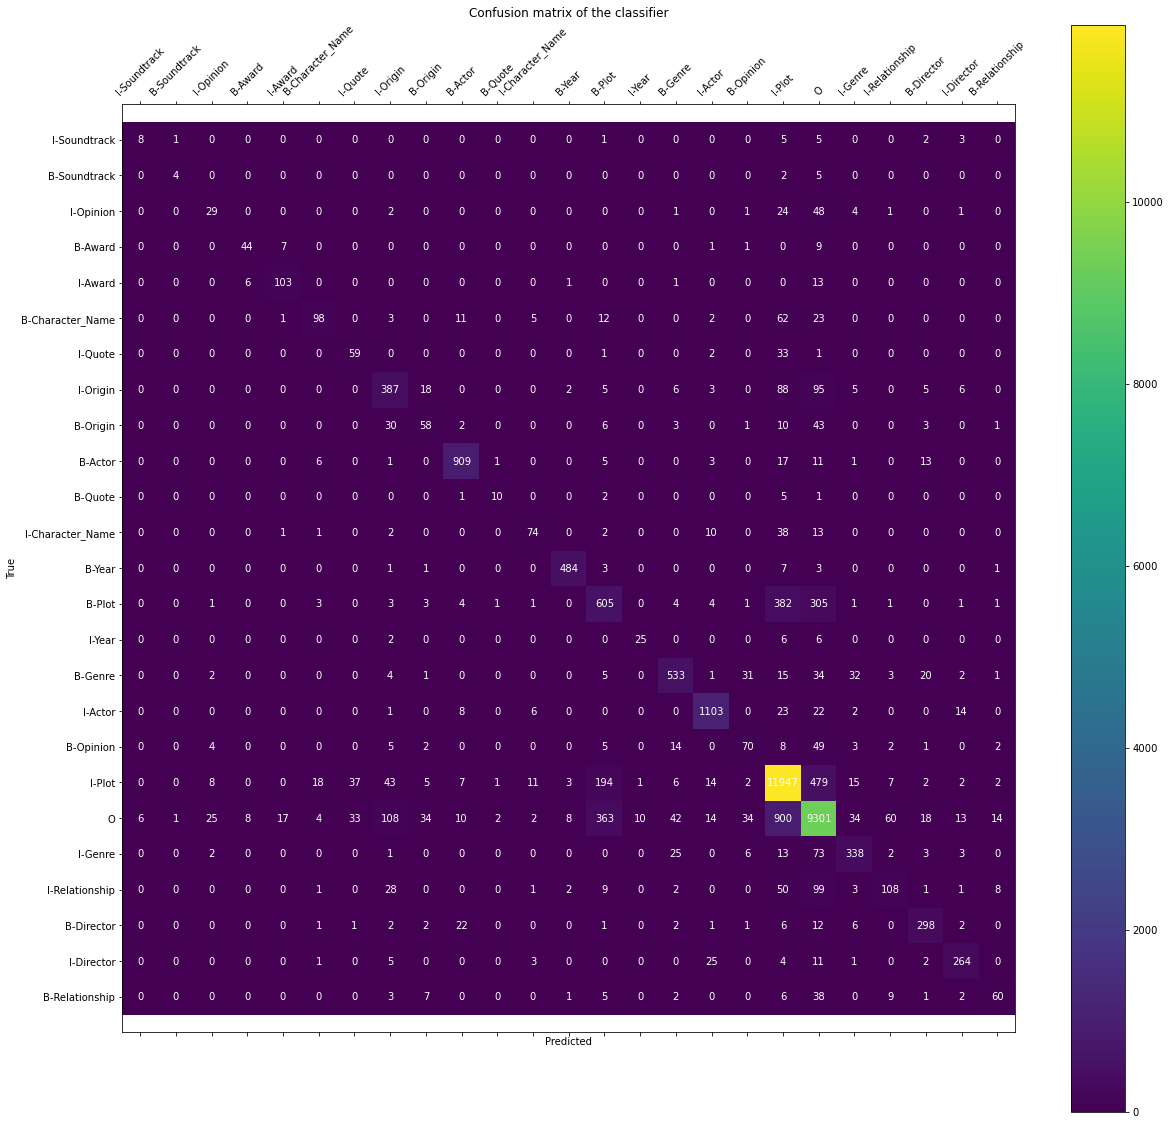

In [59]:
confusion_matrix_heatmap(q5_y_test, q5_preds)

In [60]:
# Preprocessing the given train and test data set
given_training_data = [preProcess_addTags(example) for example in given_raw_training_data]

given_test_data = [preProcess_addTags(example) for example in given_raw_test_data]

In [61]:
print("training tagger on the given set...")
final_ct.train(given_training_data, TAGGER_PATH)
print("done")

final_ct.set_model_file(TAGGER_PATH) 

training tagger on the given set...
done


In [62]:
print("testing tagger...")
q5_preds = []
q5_y_test = []
for sent in given_test_data:
    sent_preds = [x[1] for x in final_ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    q5_preds.extend(sent_preds)
    q5_y_test.extend(sent_true)
print("done")

testing tagger...
done


In [63]:
# Final report on the original data sets trivia10k13train.bio.txt and trivia10k13test.bio.txt
final_clReport = classification_report(q5_y_test, q5_preds)
final_prfsReport = precision_recall_fscore_support(q5_y_test, q5_preds, average='macro')

print(final_clReport)
print(final_prfsReport)

                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1274
         B-Award       0.69      0.71      0.70        66
B-Character_Name       0.69      0.49      0.58       283
      B-Director       0.85      0.85      0.85       425
         B-Genre       0.83      0.81      0.82       789
       B-Opinion       0.44      0.36      0.40       195
        B-Origin       0.46      0.36      0.41       190
          B-Plot       0.48      0.47      0.48      1577
         B-Quote       0.73      0.40      0.52        47
  B-Relationship       0.74      0.56      0.64       171
    B-Soundtrack       1.00      0.12      0.22         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.92      0.94      0.93      1553
         I-Award       0.78      0.80      0.79       147
I-Character_Name       0.69      0.57      0.62       227
      I-Director       0.90      0.87      0.88       411
         I-Ge

In [64]:
# Comparing precision, recall and f1-score from all the above results
print("Before splitting:")
print(given_prfsReport)
print("After splitting:")
print(q1_prfsReport)
print("Afer tagging:")
print(q4_prfsReport)
print("After 1st feature iteration:")
print(q5I1_prfsReport)
print("After 2nd feature iteration:")
print(q5I2_prfsReport)
print("Final run on the given test and train sets:")
print(final_prfsReport)

Before splitting:
(0.6581485250363811, 0.5495470870201031, 0.5838971371849242, None)
After splitting:
(0.6064850392545966, 0.513915038409207, 0.5454202155753599, None)
Afer tagging:
(0.6170083344014887, 0.5315958855358179, 0.5622765677918949, None)
After 1st feature iteration:
(0.6910049199313915, 0.5851155966208208, 0.619147308813468, None)
After 2nd feature iteration:
(0.7015624219546766, 0.6281794725837422, 0.6559503160154014, None)
Final run on the given test and train sets:
(0.7285112465570484, 0.6112976623292972, 0.6417764528189767, None)


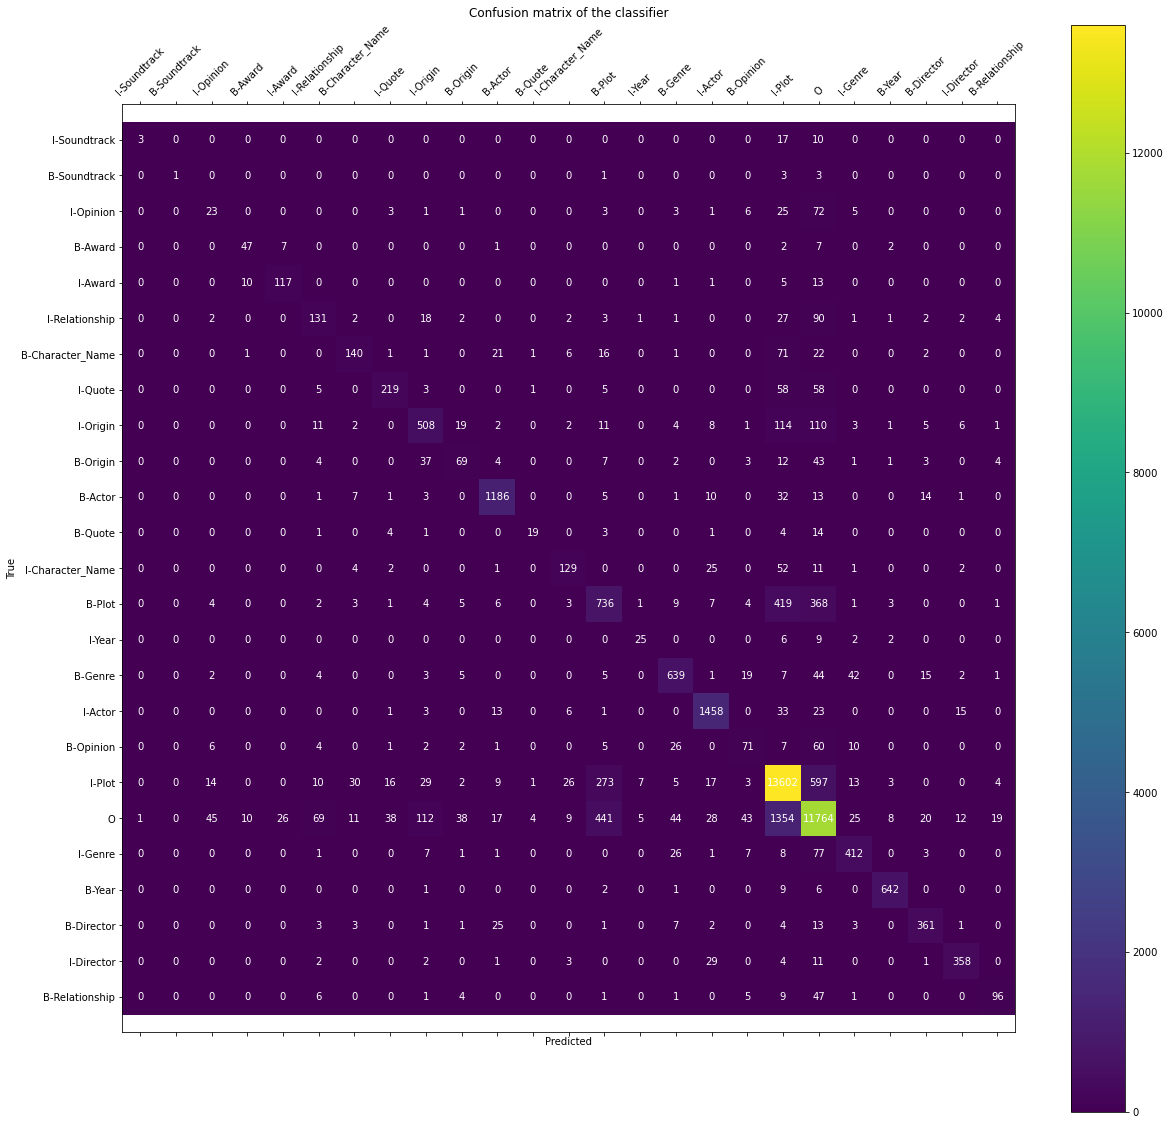

In [65]:
confusion_matrix_heatmap(q5_y_test, q5_preds)